# COVET on Spatial Pancreas data

### Pre-requisites

In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" # Change to -1 if you want to use CPU!

import warnings
warnings.filterwarnings('ignore')

In [2]:
import scenvi

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import scanpy as sc
#import colorcet
import sklearn.neighbors
import scipy.sparse
import umap.umap_ as umap
#from fa2 import ForceAtlas2

In [4]:
!pip install squidpy

### Data

In [5]:
adata_s1 = sc.read('/lustre/groups/ml01/workspace/sara.jimenez/spatial_pancreas_data/preprocessed_data/data4downstream/S1_ct_based_niche_label_npod_annotated.h5ad')
adata_s1

AnnData object with n_obs × n_vars = 108711 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max', 'niche_label'
    uns: 'CellTypes_max_colors', 'cell_type_coarse_colors', 'design_matrix', 'neighbors', 'niche_label_colors', 'pca', 'spatial', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'design_matrix', 'spatial', 'spatial_fov'
    layers: 'counts'
    obsp: 'spatial_connectivities', 'spatial_distances'

### Subsetting and pre-processing

Checking cell type annotation such that labels are homogeneous in dissociated and spatial data

In [6]:
len(adata_s1.obs['CellTypes_max'].cat.categories)

14

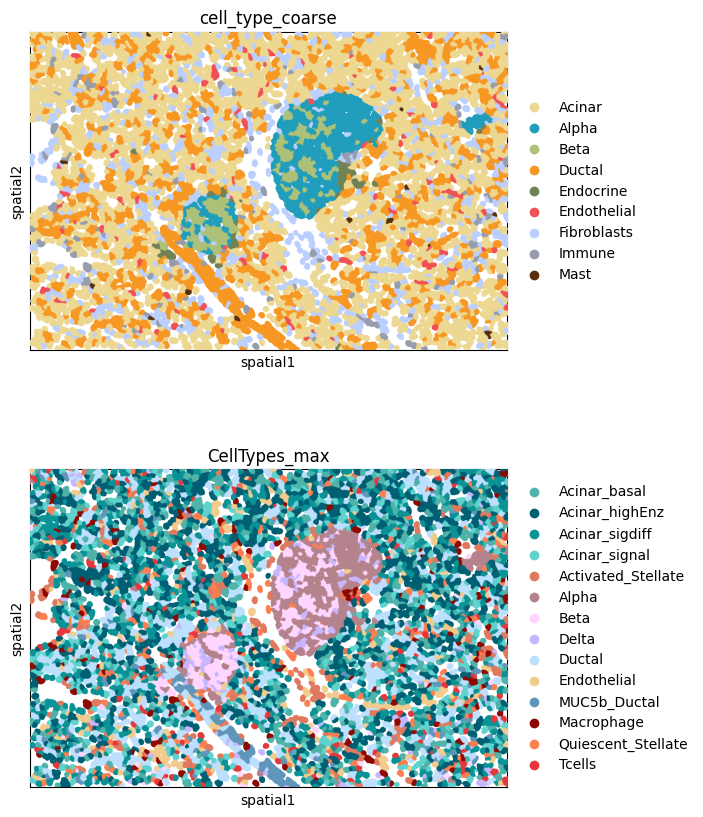

In [53]:
import squidpy as sq
sq.pl.spatial_segment(adata_s1,color=['cell_type_coarse','CellTypes_max'],library_id=['12'],
                      library_key='fov', seg_cell_id='cell_ID', img=False,ncols=1)

### Compute covet

ENVI requires un-logged counts and it doesn't work with adata.X sparse 

In [7]:
st_data = adata_s1.copy()
st_data.X = st_data.layers['counts'].toarray()

print(st_data.X.max())

st_data

285


AnnData object with n_obs × n_vars = 108711 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max', 'niche_label'
    uns: 'CellTypes_max_colors', 'cell_type_coarse_colors', 'design_matrix', 'neighbors', 'niche_label_colors', 'pca', 'spatial', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'design_matrix', 'spatial', 'spatial_fov'
    layers: 'counts'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [8]:
st_data.obs['cell_type'] = st_data.obs['CellTypes_max']

In [70]:
st_data.obsm['COVET'], st_data.obsm['COVET_SQRT'], st_data.uns['COVET_genes'] = scenvi.utils.compute_covet(st_data, k=8, g=64, genes=[], spatial_key='spatial', batch_key='fov')

In [71]:
st_data.obsm['COVET'][0].shape

(64, 64)

In [72]:
st_data.obsm['COVET_SQRT'].shape

(108711, 64, 64)

In [73]:
st_data.uns['COVET_genes']

array(['APOD', 'BAG3', 'C11orf96', 'C1QA', 'C1QB', 'C1QC', 'CALM1',
       'CASR', 'CCL2', 'CD163', 'CD59', 'CD68', 'CHGA', 'COL18A1',
       'COL1A1', 'COL1A2', 'COL3A1', 'COL4A1', 'COL4A2', 'COL6A1',
       'COL6A2', 'COL6A3', 'CXCL2', 'DCN', 'FGFR3', 'FN1', 'FOS', 'G6PC2',
       'GC', 'GCG', 'GDF15', 'GPX3', 'HLA-DRA', 'HLA-DRB1', 'HSPA1A',
       'IAPP', 'IGF2', 'IGHA1', 'IGKC', 'IL7R', 'JUNB', 'KRT19', 'LEFTY1',
       'LYZ', 'MEG3', 'MMP7', 'OLFM4', 'S100A6', 'S100A8', 'SCG5',
       'SERPINA1', 'SPARCL1', 'SPP1', 'SST', 'TACSTD2', 'TAGLN', 'THBS1',
       'TIMP1', 'TM4SF1', 'TPSAB1', 'TPSB2', 'VEGFA', 'VWF', 'ZFP36'],
      dtype='<U8')

### COVET analysis

In [74]:
st_data.obsm['COVET_SQRT_flat'] = np.reshape(st_data.obsm['COVET_SQRT'],[st_data.shape[0], -1])
st_data.obsm['COVET_SQRT_flat'].shape              

(108711, 4096)

In [75]:
sc.pp.neighbors(st_data, use_rep='COVET_SQRT_flat',n_neighbors=100)#, key_added='neighbors_covet-k=8')

In [76]:
st_data.uns['neighbors']

{'connectivities_key': 'connectivities',
 'distances_key': 'distances',
 'params': {'n_neighbors': 100,
  'method': 'umap',
  'random_state': 0,
  'metric': 'euclidean',
  'use_rep': 'COVET_SQRT_flat'}}

In [77]:
sc.tl.umap(st_data, min_dist=0.1)#,neighbors_key='neighbors_covet-k=8')

In [78]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(st_data, flavor="igraph", n_iterations=2,key_added='leiden_covet',resolution=0.1)

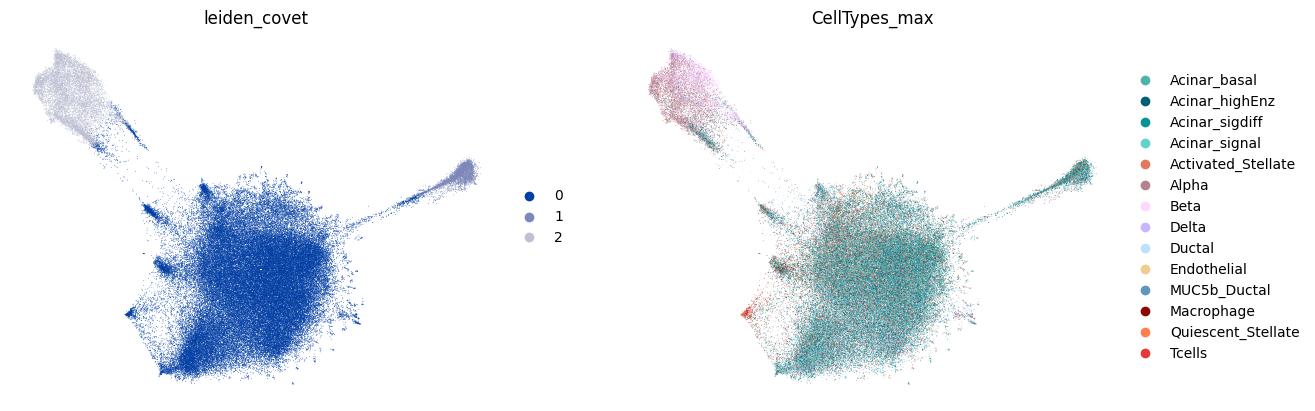

In [79]:
sc.pl.umap(st_data, color=["leiden_covet","CellTypes_max"],frameon=False)

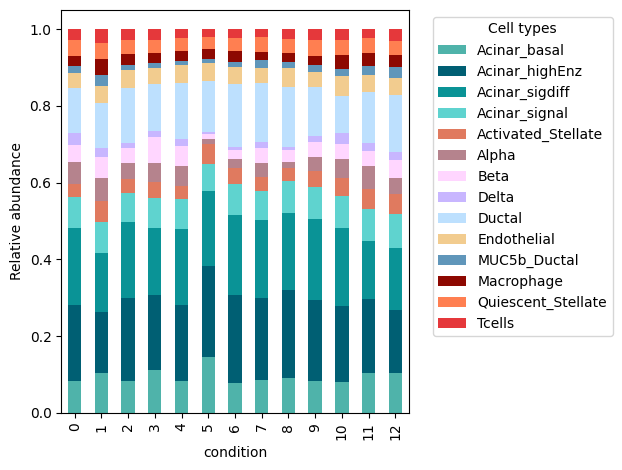

In [59]:
# Step 1: Group observations by 'condition' and count each 'CellTypes_max' entry
counts = st_data.obs.groupby(['leiden_covet', 'CellTypes_max']).size().unstack(fill_value=0)

# Step 2: Calculate relative abundance (proportion) by normalizing counts within each condition
relative_abundance = counts.div(counts.sum(axis=1), axis=0)

#colors 
colors = ['#4FB3AA',#'Acinar_basal'
          '#005F73',#'Acinar_highEnz', 
          '#0A9396',#'Acinar_sigdiff', 
          '#5FD3CF',#'Acinar_signal',
          '#e07a5f',#'Activated_Stellate', 
          '#b5838d',#'Alpha', 
          #'#f8ad9d',#'Bcells', 
          '#ffd6ff',#'Beta', 
          '#c8b6ff',#'Delta', 
          '#bde0fe',#'Ductal',
          '#f2cc8f',#'Endothelial', 
          #'#ffa62b',#'LymphEndo', 
          '#6096ba',#'MUC5b_Ductal', 
          '#8d0801',#'Macrophage', 
          #'#4f000b',#'Mast',
          '#ff7f51',#'Quiescent_Stellate', 
          #'#ce4257',#'Schwann', 
          '#e5383b',#'Tcells'
]

# Plot a stacked bar chart
ax = relative_abundance.plot(kind='bar', stacked=True,color=colors)

# Customize the plot (labels, title, etc.)
plt.xlabel('condition')
plt.ylabel('Relative abundance')
#plt.title('Stacked Bar Plot of Counts per Category')
plt.xticks(rotation=90)
# Step 3: Position the legend outside the plot
plt.legend(title='Cell types', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout()


# Show the plot
plt.show()

In [27]:
all_genes = list(st_data.var_names)
covet_genes = list(st_data.uns['COVET_genes'])

# Determine the largest list size
max_size = max(len(all_genes), len(covet_genes))

# Create an array of zeros with the size of the largest list
comparison_array = np.zeros(max_size, dtype=int)

# Fill in the comparison array
for i, gene in enumerate(all_genes):
    if gene in covet_genes:
        comparison_array[i] = 1  # Mark as match

In [29]:
sc.tl.rank_genes_groups(st_data, groupby='leiden_covet',mask_var=comparison_array.astype(bool))

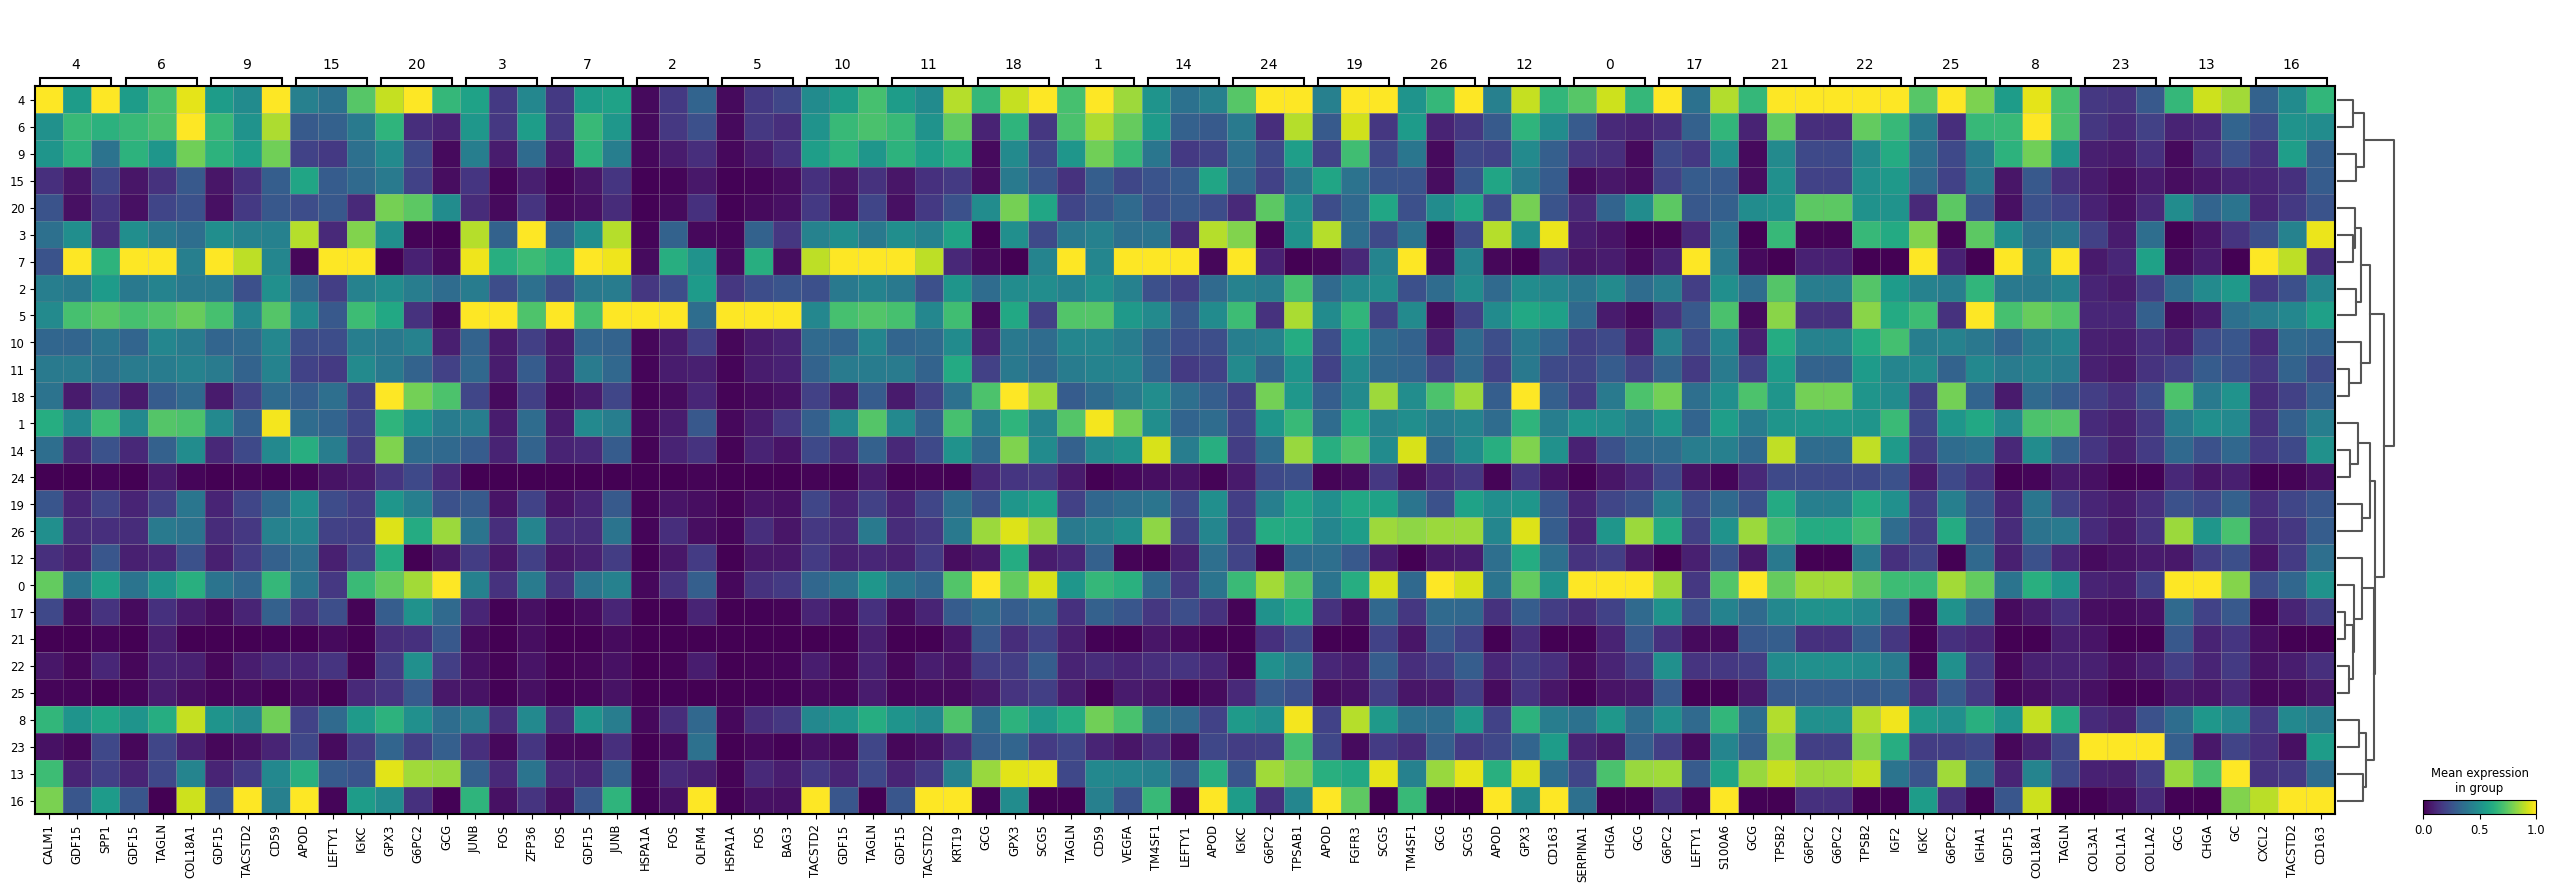

In [31]:
sc.pl.rank_genes_groups_matrixplot(st_data, n_genes=3, standard_scale='var')

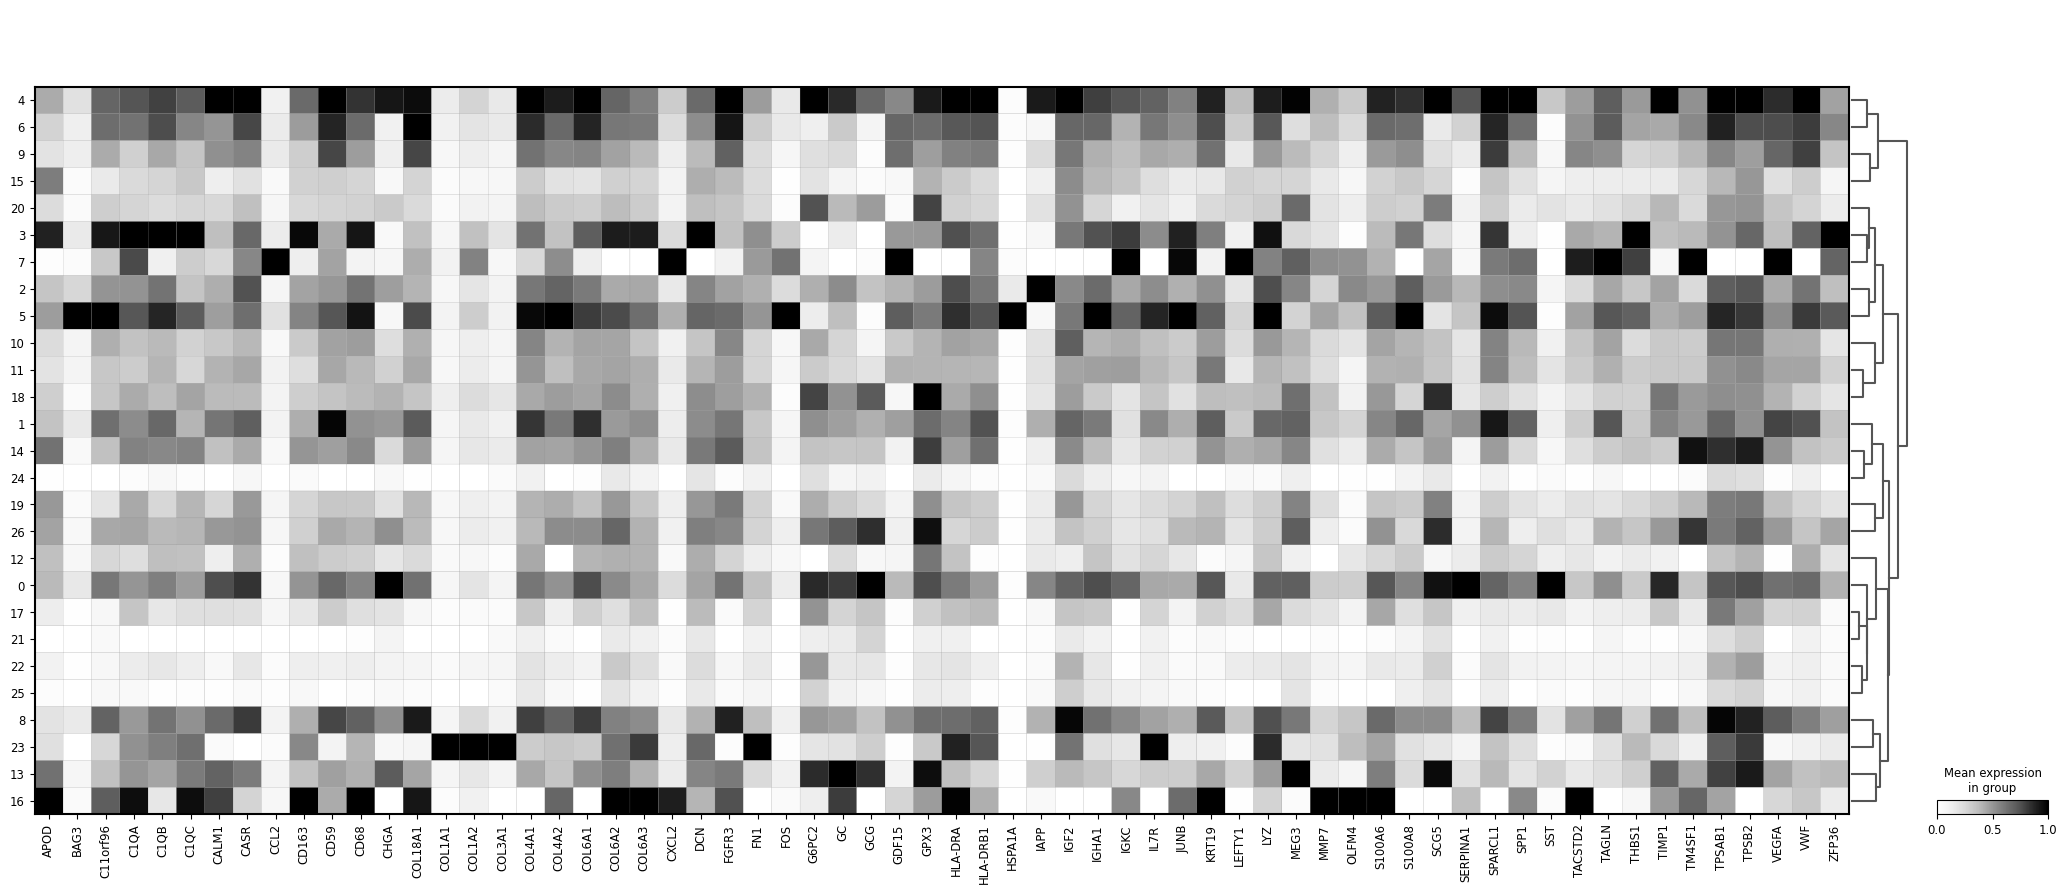

In [42]:
sc.pl.matrixplot(st_data, st_data.uns['COVET_genes'], groupby='leiden_covet',cmap='Greys',standard_scale='var', dendrogram=True)

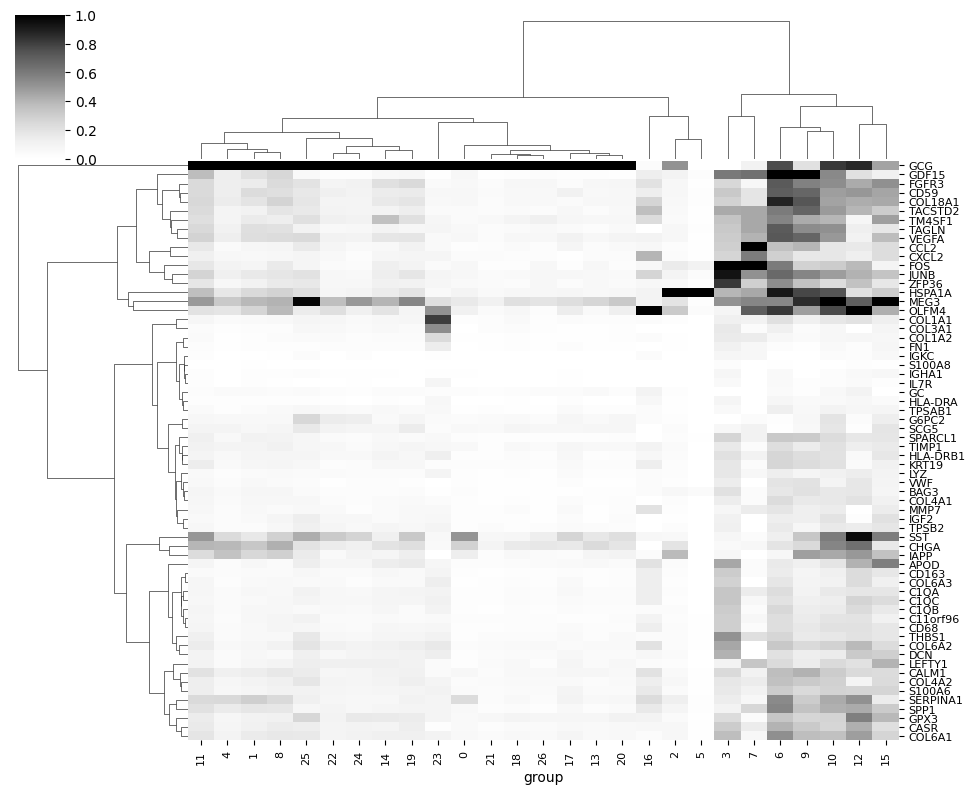

In [36]:
# 1. Subset the AnnData object to include only the genes you're interested in
genes_of_interest = st_data.uns['COVET_genes']  # Replace with your gene set

# 2. Extract expression data for the genes
# Use .raw if you want to use raw data, otherwise use adata.X (processed)
gene_expr_data = pd.DataFrame(
    st_data[:, genes_of_interest].X,   # Extracts expression data for the specified genes
    index=st_data.obs_names,           # Cell names
    columns=genes_of_interest        # Gene names
)

# 3. Group by a field in `obs` (e.g., cluster or cell type)
group_field = 'leiden_covet'  # Replace with the field you want to group by, e.g., 'leiden', 'cell_type'
gene_expr_data['group'] = st_data.obs[group_field]

# 4. Aggregate the gene expression data by the grouping field
grouped_data = gene_expr_data.groupby('group').mean()

# 5. Plot the clustermap with Seaborn
g = sns.clustermap(
    grouped_data.T,                     # Transpose to have genes on the x-axis, clusters on the y-axis
    standard_scale=1,                   # Standardize across the genes (columns)
    cmap='Greys',                     # Colormap for the heatmap
    figsize=(10, 8),                    # Set the figure size
    metric='euclidean',                 # Distance metric for clustering (can be 'euclidean', 'correlation', etc.)
    method='ward',                       # Clustering method (can be 'ward', 'average', 'single', etc.)
    xticklabels=True,                  # Show x-axis labels (genes)
    yticklabels=True                   # Show y-axis labels (groups)
)

# 6. Rotate the x-axis labels (gene names) for readability
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90)

# 7. Optionally, adjust font size for better visibility
g.ax_heatmap.tick_params(axis='x', labelsize=8)  # Change font size for x-axis
g.ax_heatmap.tick_params(axis='y', labelsize=8)  # Change font size for y-axis


In [37]:
st_data

AnnData object with n_obs × n_vars = 108711 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max', 'niche_label', 'cell_type', 'leiden_covet'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CellTypes_max_colors', 'cell_type_coarse_colors', 'design_matrix', 'neighbors', 'niche_label_colors', 'pca', 'spatial', 'spatial_neighbors', 'umap', 'hvg', 'COVET_genes', 'leiden_covet', 'leiden_covet_colors', 'rank_genes_